<a href="https://colab.research.google.com/github/abalaji-blr/DCGAN/blob/master/DCGAN_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Generation Using DC-GAN


In [9]:
!nvidia-smi

Sat Dec 14 07:56:59 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import Data

## Image Collection
A set of car images are collected from Google. Three category of cars sedan, SUV and Hatchbacks were selected with only side view with the intention of implementing a AC-GAN but due to complexity of the convergence simple DC-GAN architecture was decided.

The images are scaled to fit $64\times64$.

In [10]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import os
    os.chdir('/content')
    if not os.path.isdir('/content/DCGAN/'):
        !git clone https://github.com/abalaji-blr/DCGAN.git
    os.chdir('/content/DCGAN')
    !pwd
    
    !git status

/content/DCGAN
On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	discriminator_plot.png
	gen_plot_e011.png
	generator_plot.png

nothing added to commit but untracked files present (use "git add" to track)


## Imports

In [0]:
%tensorflow_version 1.x

In [0]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Flatten, Reshape, Dense, Concatenate, Conv2DTranspose, BatchNormalization, Activation, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, MaxPool2D, Dropout
from tensorflow.keras.layers import add, Input, Dense, Flatten, GlobalAvgPool2D, GlobalAvgPool1D, LeakyReLU
from tensorflow.keras.initializers import zeros
from tensorflow.keras.initializers import RandomNormal

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Resize and Standardize Images


The images are standardized to have pixel ranges from [-1, 1]. 

This is to ensure they are fitting to the generator convention that follows a $tanh$ activation.

In [13]:
import cv2
import os
import numpy as np
from os import listdir
from os.path import join

car_types = ['hatch', 'sedan', 'suv']

def resize_image(img, size=(64,64)):

    h, w = img.shape[:2]

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        c = img.shape[2]
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

spath, dpath = join('data', 'cars'), join('data', 'norm')

if not os.path.isdir(dpath):
    os.mkdir(dpath)

imgs = {}


for ct in car_types:
    sp, dp = join(spath, ct), join(dpath, ct)
    alen = 1024
    imgs[ct] = np.zeros((1024, 64, 64, 3))
    if not os.path.isdir(dp):
        os.mkdir(dp)
    tlen = 0
    for f in listdir(sp):
        sf, df = join(sp, f), join(dp, f)
        img = cv2.imread(sf)
        img = resize_image(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tlen += 1
        if tlen > alen:
            imgs[ct] = np.append(imgs[ct], np.zeros((1024, 64, 64, 3)))
            alen += 1024
        imgs[ct][tlen-1] = img
    imgs[ct] = imgs[ct][:tlen]
    print(imgs[ct].shape)

(332, 64, 64, 3)
(410, 64, 64, 3)
(337, 64, 64, 3)


## Generate More Data Using Augmentation

In [0]:
#trainX = imgs['hatch']
# can include suv images as well. Let's try with only two categories.
data = np.append(imgs['hatch'], imgs['sedan'], axis=0)

In [15]:
data.shape

(742, 64, 64, 3)

In [0]:
from tensorflow.keras import utils 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(data)

trainX = data

for i in range(9):
    iterate = datagen.flow(data, batch_size=len(data), shuffle=True)
    x = iterate.next()
    trainX = np.append(trainX, x, axis=0)

In [17]:
trainX.shape

(7420, 64, 64, 3)

## Convert the data

Convert the data from [0,255] to [-1, 1].
Note that generator uses tanh activation.

In [0]:
def convert_input_data(X):
  X = X.astype('float32')

  # shift the data from [0, 255] to [-1, 1]
  X = (X - 127.5) / 127.5
  return X  

In [0]:
trainX = convert_input_data(trainX)

In [20]:
print(trainX.shape)

(7420, 64, 64, 3)


## DCGAN Design

Deep convolution GAN is a simple convolution network that learns the complexities of image features and regenerates images. The GAN is composed of 2 components.

* Discriminator
* Generator

The discriminator is trained to distinguish between, real and fake. While the generator is trained to create such images that can pass through the discriminator's judgement. The adversial nature of training leads to creation of new patterns of images.

The code used here is a modification of code at: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

## Build Discriminator

The discriminator is a simple sequential convolution network of $3x3$ kernels with LeakyReLU. LeakyReLU is suggested as it has better smoothening properties.

In [0]:
# Code from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

# l2 regularization
L2_REG=1e-3

# compute weights
def l2_weights(model):
    l2 = 0
    for layer in model.layers: 
        if isinstance(layer, Model):
            continue
        wts = layer.weights
        if len(wts) > 0:
            for wt in wts:
                l2 += K.sum(wt*wt)
    return l2

# compute l2 loss
def l2_loss(model, f):
    def loss(yt, yp):
        return f(yt, yp) + L2_REG*l2_weights(model)
    return loss

# binary cross entropy with label_smoothing = 0.1
# probability of [0.9 and 0.1] instead of [0 1] for the classes.
# label smoothing will help in train around mislabeled data and 
# imporove the performace.
bce = lambda yt, yp: binary_crossentropy(yt, yp, label_smoothing=0.1)

# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, (3,3), padding= 'same' , input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation= 'sigmoid' ))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss= l2_loss(model, bce) , optimizer=opt, metrics=[ 'binary_accuracy' ])
  return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_2

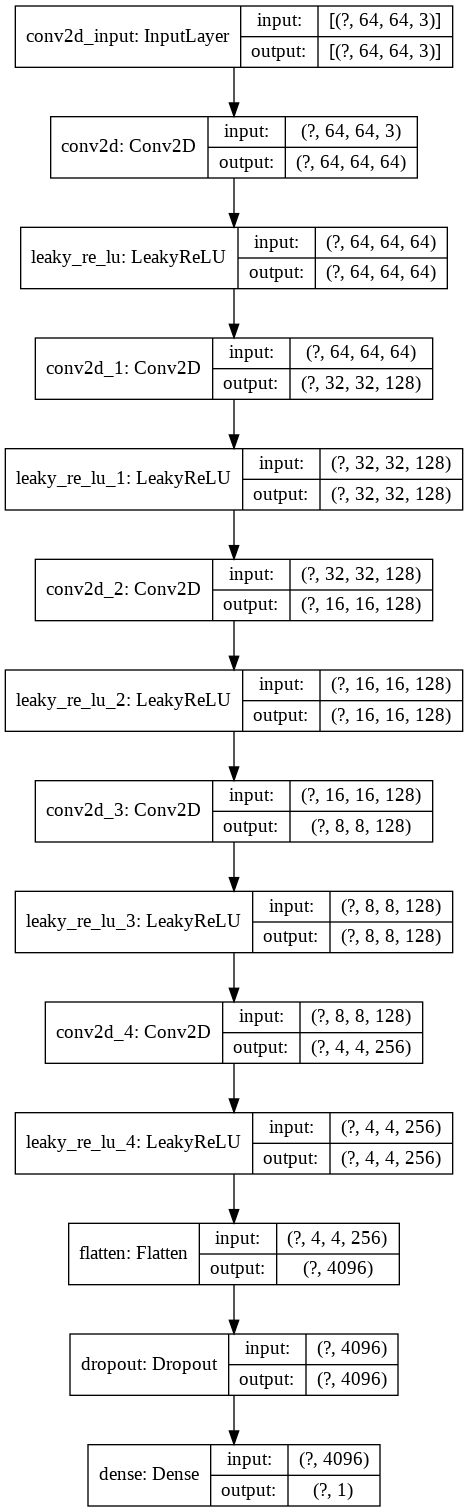

In [22]:
# define model
D = define_discriminator()
# summarize the model
D.summary()
# plot the model
plot_model(D, to_file= 'discriminator_plot.png' , show_shapes=True, show_layer_names=True)

## Training Discriminators

Discriminators are standalone networks and can be independently trained as well with real and fake images. Fake images in this context can be natural random images. However, such training must be minimal to just overcome initial bias towards setting all values to zeros. But discriminant must be trained with the generator and should not be over trained. If it's then generator will find it harder to generate images to bypass discriminator.

In [0]:
# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate  real  class labels (1)
  y = np.ones((n_samples, 1))
  return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    X = np.random.rand(64 * 64 * 3 * n_samples)
    X = -1 + X * 2
    X = X.reshape((n_samples, 64, 64, 3))
    y = np.zeros((n_samples, 1))
    return X, y

# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        real_res = model.train_on_batch(X_real, y_real)

        
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        fake_res = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%3d  real=%5.0f%% fake=%5.0f%%' % (i+1, real_res[1]*100, fake_res[1]*100))

In [24]:
train_discriminator(D, trainX)

>  1  real=   55% fake=    0%
>  2  real=  100% fake=    0%
>  3  real=  100% fake=    0%
>  4  real=  100% fake=   14%
>  5  real=  100% fake=   78%
>  6  real=   98% fake=  100%
>  7  real=  100% fake=  100%
>  8  real=   98% fake=  100%
>  9  real=   97% fake=  100%
> 10  real=  100% fake=  100%
> 11  real=   98% fake=  100%
> 12  real=   97% fake=  100%
> 13  real=   98% fake=  100%
> 14  real=  100% fake=  100%
> 15  real=  100% fake=  100%
> 16  real=  100% fake=  100%
> 17  real=  100% fake=  100%
> 18  real=  100% fake=  100%
> 19  real=  100% fake=  100%
> 20  real=  100% fake=  100%


## Build Generator

Generator takes a latent dimension vector and applies the inverse operation of transposed convolution and LeakyReLU to arrive at the images. Normally a larger kernel is used for convolutions. Here (4,4) is used though several texts have suggested 5x5.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)      

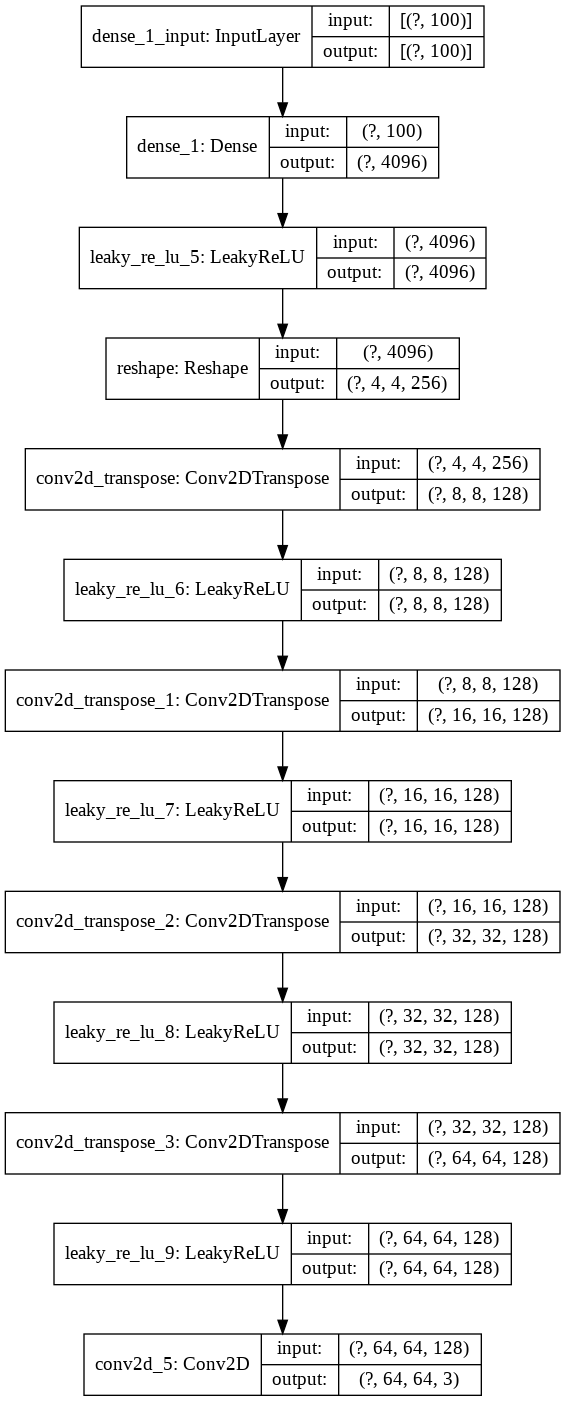

In [25]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 4x4 image
  n_nodes = 256 * 4 * 4
                                                                                                             
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 64x64
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2)) 
  # output layer
  model.add(Conv2D(3, (3,3), activation= 'tanh' , padding= 'same' ))
  return model

latent_dim = 100
# create the generator
G = define_generator(latent_dim)
# summarize the model
G.summary()
# plot the model
plot_model(G, to_file= 'generator_plot.png' , show_shapes=True, show_layer_names=True)

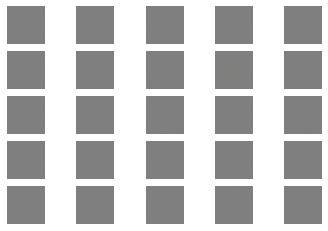

In [26]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=2):
  # get the random points from normal distribution
  x_input = np.random.randn(latent_dim * n_samples)
  
  data = x_input.reshape(n_samples, latent_dim)
  return (data)

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # get the latent space
  data   = generate_latent_points(latent_dim, n_samples)

  # get the images and their labels
  images = g_model.predict(data)

  # tag them as fake (which is class 0 for discriminator)
  fake = np.zeros((n_samples, 1))

  return(images, fake)

# size of the latent space
latent_dim = 100
 
# generate samples
n_samples = 25
X, _ = generate_fake_samples(G, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis labels
    plt.axis('off')
    # plot single image
    plt.imshow(X[i])
# show the figure
plt.show()

## Define GAN and Training Generators

Generator is trained as a dependent network of a discriminator. The GAN training network takes the latent vector as input and generates images through generator. The output of the generator is fed into the discriminator and generator is trained with the image be passed through the discriminator as a valid input. Since, the discriminator component is marked untrainable, the generator trains itself on generating better images that can pass through the discriminator.

The binary_crossentropy loss is used. However, the L2-regularization is added to overcome mode collapse. The size of the latent vector also drives setting up the number of modes in the network.

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  #model.compile(loss= binary_crossentropy , optimizer=opt)
  model.compile(loss=l2_loss(model, bce), optimizer=opt, metrics=['acc'])
  return model

In [28]:
# create the gan
gan_model = define_gan(G, D)
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 64, 64, 3)         1728387   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 670081    
Total params: 2,398,468
Trainable params: 1,728,387
Non-trainable params: 670,081
_________________________________________________________________


## Training Utilities

In [0]:
# At regular intervals during training process
# generate images from generator
# and also, save model
#
# def summarize_performance(step, gen_model, latent_dim, n_samples=25):
#   # get the generated images
#   fake_images, _ = generate_fake_samples(gen_model, latent_dim, n_samples)

#   # scale the images from [-1,1] to [0,1]
#   fake_images = (fake_images + 1) / 2.0

#   # plot images
#   for i in range(25):
#     plt.subplot(5, 5, 1+i)
#     plt.axis('off')
#     plt.imshow(fake_images[i])

#   # save the plot to file
#   filename = 'gen_plot_%04d.png' % (step+1)
#   plt.savefig(filename)
#   plt.close()

#   # save the model as well
#   model_file = 'gen_model_%04d.hdf5' % (step+1)
#   #gen_model.save(model_file)
#   print('Saved: %s and %s' % (filename, model_file))

In [0]:
def save_plot(examples, epoch, n=10):
    target = 1000
    dpi=72
    margin=0.1
    size = target/((1.-2*margin)*dpi)
    fig = plt.figure(figsize=(size, size), dpi=dpi)
    fig.subplots_adjust(left=margin, right=1.-margin, wspace = 0.01, hspace=0.01)
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i])

    filename = 'gen_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

    # plot the generated images
    save_plot(x_fake, epoch)
    #filename = 'generator_model_%03d.h5' % (epoch+1)
    #g_model.save(filename)

## Training of GAN

The training is not carried out with standard epoch based method but carried out in single batches of alternate discriminator and generator. To be noted here, there is a potential of the network getting overfitted to one side and rejecting all fakes and thus make the training of the network extremely hard. To avoid this we introduce 5% errors in the data itself. Moreover label smoothing is carried out in the binary entropy calculation to avoid strong biases towards zeros or ones.

The images are generated in every 200 iterations and saved for comparison.

In [0]:
# # train the generator and discriminator
# def train(g_model, d_model, gan_model, trainX, latent_dim, n_epochs=100, n_batch=128):
#   # calculate the number of batches per training epoch
#   bat_per_epo = int(trainX.shape[0] / n_batch)

#   # calculate the number of training iterations
#   n_steps = bat_per_epo * n_epochs
#   print('Total steps:', n_steps)

#   # calculate the size of half a batch of samples
#   half_batch = int(n_batch / 2)

#   # manually enumerate epochs
#   for i in range(n_steps):
#     ####
#     ## training discrimintor
#     ####
#     # get randomly selected  real  samples
#     X_real, y_real = generate_real_samples(trainX, half_batch)
#     # update discriminator model weights
#     d_loss1, _ = d_model.train_on_batch(X_real, y_real)

#     # generate  fake  examples
#     X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
#     # update discriminator model weights
#     d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

#     ####
#     ## training generator
#     ####
#     # prepare points in latent space as input for the generator
#     X_gan = generate_latent_points(latent_dim, n_batch)
#     # create inverted labels for the fake samples
#     y_gan = np.ones((n_batch, 1))

#     # update the generator via the discriminator s error
#     g_loss = gan_model.train_on_batch(X_gan, y_gan)
    
    
#     if (i+1) % (bat_per_epo * 1) == 0:
#       # summarize loss on this batch
#       print( '>%d, d1[%.3f], d2[%.3f], g[%.3f]'  % 
#           (i+1, d_loss1, d_loss2, g_loss))
      
#     # evaluate the model performance every  epoch
#     if (i+1) % (bat_per_epo * 10) == 0:
#      summarize_performance(i, g_model, latent_dim)

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # inject 5% errors intentionaly
            y_real[np.random.randint(0, half_batch, (3,))] = 0.0
            
            d_res1 = d_model.train_on_batch(X_real, y_real)
            
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # inject 5% errors intentionally
            y_fake[np.random.randint(0, half_batch, (3,))] = 1.0

            d_res2 = d_model.train_on_batch(X_fake, y_fake)
                
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            # inject 5% errors intentionally
            y_gan[np.random.randint(0, half_batch, (6,))] = 0

            g_res = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%10.4e, d2=%10.4e g=%10.4e' %
                  (i+1, j+1, bat_per_epo, d_res1[0], d_res2[0], g_res[0]))
        if i%200 == 199:
            summarize_performance(i, g_model, d_model, dataset, latent_dim, n_samples=150)

## Traning

In [33]:
# train model
train(G, D, gan_model, trainX, latent_dim, n_epochs=600, n_batch=128)

>1, 1/57, d1=8.2227e-01, d2=1.0698e+00 g=8.6736e-01
>1, 2/57, d1=8.1155e-01, d2=1.0180e+00 g=9.6205e-01
>1, 3/57, d1=7.6197e-01, d2=9.4749e-01 g=1.1781e+00
>1, 4/57, d1=7.9994e-01, d2=8.5945e-01 g=1.5070e+00
>1, 5/57, d1=8.8585e-01, d2=8.3159e-01 g=1.4910e+00
>1, 6/57, d1=7.7358e-01, d2=8.0641e-01 g=1.7682e+00
>1, 7/57, d1=7.9840e-01, d2=7.7737e-01 g=2.0909e+00
>1, 8/57, d1=7.8555e-01, d2=7.7308e-01 g=2.2329e+00
>1, 9/57, d1=7.9723e-01, d2=7.9392e-01 g=3.0160e+00
>1, 10/57, d1=8.0181e-01, d2=7.8241e-01 g=1.8669e+00
>1, 11/57, d1=7.8935e-01, d2=1.2344e+00 g=2.1231e+00
>1, 12/57, d1=7.9655e-01, d2=8.3257e-01 g=5.8542e+00
>1, 13/57, d1=1.4714e+00, d2=7.6723e-01 g=1.2877e+00
>1, 14/57, d1=8.2059e-01, d2=8.9661e-01 g=1.4867e+00
>1, 15/57, d1=8.2238e-01, d2=7.7551e-01 g=2.0075e+00
>1, 16/57, d1=8.5161e-01, d2=7.2890e-01 g=2.0492e+00
>1, 17/57, d1=8.5035e-01, d2=7.5027e-01 g=1.9667e+00
>1, 18/57, d1=8.1687e-01, d2=7.5510e-01 g=1.9225e+00
>1, 19/57, d1=7.7124e-01, d2=7.5251e-01 g=2.0316e+00
>1

In [0]:
G.save('generator_model.hdf5')

In [0]:
D.save('discriminator_model.hdf5')

In [0]:
gan_model.save('gan_model.hdf5')

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp *.png '/content/drive/My Drive/App/EVA/Session19/dcgen_gen_images'

In [0]:
!cp *.hdf5 '/content/drive/My Drive/App/EVA/Session19/dcgen_gen_images'